#A/B Тест
## Импортируем необходимые библиотеки

In [ ]:
import pandas as pd
import statsmodels.stats.api as sms
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from matplotlib import pyplot as plt
import numpy as np
from sklearn import preprocessing
from scipy.stats import ttest_ind

## Загрузим исходные данные 

In [ ]:
active_studs = pd.read_csv("/content/active_studs.csv")
checks = pd.read_csv("/content/checks.csv",sep=';')
groups = pd.read_csv("/content/groups.csv",sep=';')

In [ ]:
checks.info()
active_studs.info()
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


## Преобразуем таблицы для дальнейших расчетов

In [ ]:
active_studs_grp = pd.merge(active_studs, groups, left_on='student_id', right_on='id').drop("id", axis=1) # таблица активных пользователей и группы, к которой они принадлежат
active_studs_grp.head()

,student_id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B


In [ ]:
active_studs_a = pd.merge(active_studs, groups.loc[groups["grp"] == "A"], left_on='student_id', right_on='id').drop("id", axis=1) #Таблица активных пользователей из группы А
active_studs_b = pd.merge(active_studs, groups.loc[groups["grp"] == "B"], left_on='student_id', right_on='id').drop("id", axis=1) #Таблица активных пользователей из группы B
checks_a = pd.merge(checks, groups.loc[groups["grp"] == "A"], left_on='student_id', right_on='id').drop("id", axis=1) #Таблица пользователей совершивших покупку из группы А
checks_b = pd.merge(checks, groups.loc[groups["grp"] == "B"], left_on='student_id', right_on='id').drop("id", axis=1) #Таблица пользователей совершивших покупку из группы А

## Оценим изменение конверсии между группами А и B, используя показатель CR активных пользователей в покупку

#### Визуально на графике показатели практически не отличаются

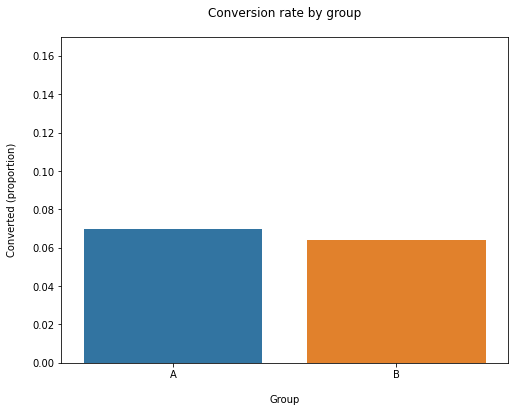

In [ ]:
CR_a = checks_a.student_id.nunique()/active_studs_a.student_id.nunique() #CR для группы А
CR_b = checks_b.student_id.nunique()/active_studs_b.student_id.nunique() #CR для группы B


plt.figure(figsize=(8,6))

sns.barplot(x=["A","B"], y=[CR_a,CR_b])

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

#### Проведем z-test и получим, что отличия двух выборок статистически незначимы и мы не можем отклонить нулевую гипотезу о равенстве распределений

In [ ]:

n_a = active_studs_a.student_id.nunique()
n_b = active_studs_b.student_id.nunique()
successes = [checks_a.student_id.nunique(), checks_b.student_id.nunique()]
nobs = [n_a, n_b]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_a, lower_b), (upper_a, upper_b) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for A group: [{lower_a:.3f}, {upper_a:.3f}]')
print(f'ci 95% for B group: [{lower_b:.3f}, {upper_b:.3f}]')

z statistic: 0.83
p-value: 0.406
ci 95% for A group: [0.057, 0.082]
ci 95% for B group: [0.058, 0.070]


## Предположим, что новая механика оплаты может повлиять на итоговую сумму, которую пользователь потратит. Проверим, изменилось ли количество денег, которые пользователь тратит на покупку занятий. 

#### Сравним показатели ARPAU и заметим, что разница уже более существенная

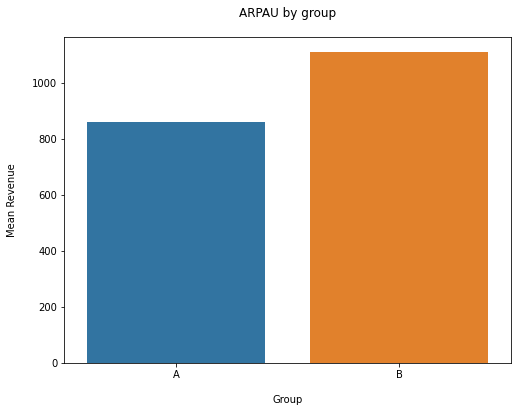

ARPAU in group A: 860.7102803738318
ARPAU in group b: 1108.824893087558


In [ ]:
ARPAU_a = checks_a.rev.mean()
ARPAU_b = checks_b.rev.mean()

plt.figure(figsize=(8,6))
sns.barplot(x=["A","B"], y=[ARPAU_a,ARPAU_b])

plt.title('ARPAU by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Mean Revenue', labelpad=15)
plt.show()
print(f"ARPAU in group A: {ARPAU_a}")
print(f"ARPAU in group b: {ARPAU_b}")

#### Используем bootstrap для семплирования и проведем t-test на получившихся выборках

In [ ]:
mean_cost_a = []
mean_cost_b = []
np.random.seed(1)
for i in range(1000):
    sample_a = np.random.choice(checks_a.rev, checks_a.rev.size, replace=True)
    sample_b = np.random.choice(checks_b.rev, checks_b.rev.size, replace=True)
    mean_cost_a.append(sample_a.mean())
    mean_cost_b.append(sample_b.mean())

mean_cost_a = np.asarray(mean_cost_a)
mean_cost_b = np.asarray(mean_cost_b) 

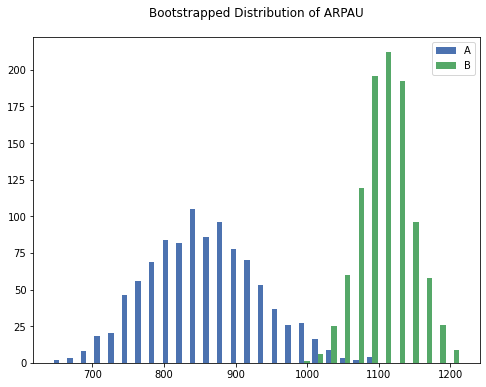

In [ ]:
plt.figure(figsize=(8,6))
plt.style.use('seaborn-deep')
plt.title('Bootstrapped Distribution of ARPAU', pad=20)
plt.hist([mean_cost_a, mean_cost_b], label=['A', 'B'], bins=30)
plt.legend(loc='upper right')
plt.show()

#### Приходим к выводу, что средние затраты одного пользователя статистически значимо увеличились.

In [ ]:
stat, p = ttest_ind(mean_cost_a, mean_cost_b, equal_var=False)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=-93.712, p=0.000
Different distributions (reject H0)


### Таким образом, новая форма оплаты не влияет на количество покупок на сайте, но увеличивает сумму покупки. Исходя из вышесказанного, запуск новой механики оплаты скорее всего положительно отразится на финансовом результате компании.
